# Dr Dennett's Guide to Spatial Interaction Modelling -  Part 2b: Constrained Models - doubly constrained

Code translated to Python by Philip Wilkinson

## Recap

Last workshop we built on our knowledge of unconstrained models by introducing the two singly constrained models. Within these models, more information can be added in, if it is available, in order to improve the model fit. We also covered some potential use cases. We could see that by adding constraints in the model, using information that we already had, could improve how well the model is able to model flows between boroughs, but also we could choose the model depending on what behaviour or values we would like to change to see how it would in theory affect flows.

This week we will build on that by introducing the doubly constrained model which contains as much information as possible into the model. Before that however, we need to bring in the data from the first practical so taht we can use it to cmopare the results of the new practical:

In [1]:
#import the necessary libraries 
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
import numpy as np
from math import sqrt
import statsmodels.formula.api as smf

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [2]:
#set up the metric calculations
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [3]:
#read in the cdatasub from the first week
cdatasub = pd.read_csv("Data/cdatasub1.csv", index_col=0)

In [4]:
cdatasub.columns

Index(['OrigCodeNew', 'DestCodeNew', 'TotalNoIntra', 'Orig', 'OrigCode',
       'Dest', 'DestCode', 'Total', 'WorksFromHome', 'Underground', 'Train',
       'Bus', 'Taxi', 'CarDrive', 'CarPass', 'Motobike', 'Bicycle', 'Walk',
       'Other', 'Oi1_origpop', 'Oi2_origsal', 'Dj1_destpop', 'Dj2_destsal',
       'offset', 'Dist', 'unconstrainedEst1', 'log_Oi1_origpop',
       'log_Dj2_destsal', 'log_Dist', 'unconstrainedEst2', 'fitted'],
      dtype='object')

In [5]:
cdatasub.head(10)

,OrigCodeNew,DestCodeNew,TotalNoIntra,Orig,OrigCode,Dest,DestCode,Total,WorksFromHome,Underground,...,Dj1_destpop,Dj2_destsal,offset,Dist,unconstrainedEst1,log_Oi1_origpop,log_Dj2_destsal,log_Dist,unconstrainedEst2,fitted
1,E09000001,E09000002,6,City of London,00AA,Barking and Dagenham,00AB,6,0,3,...,56000,16200,0.0,15995.228542,121,9.392662,9.692767,9.680046,20,20.489486
2,E09000001,E09000003,14,City of London,00AA,Barnet,00AC,14,0,11,...,159000,18700,0.0,13935.670950,184,9.392662,9.836279,9.542207,32,31.512083
3,E09000001,E09000004,0,City of London,00AA,Bexley,00AD,0,0,0,...,112000,18300,0.0,17359.908682,116,9.392662,9.814656,9.761919,22,22.318539
4,E09000001,E09000005,16,City of London,00AA,Brent,00AE,16,0,10,...,127000,16500,0.0,13119.797208,183,9.392662,9.711116,9.481878,28,27.914377
5,E09000001,E09000006,0,City of London,00AA,Bromley,00AF,0,0,0,...,164000,19100,0.0,18740.822949,104,9.392662,9.857444,9.838459,22,21.501729
6,E09000001,E09000007,335,City of London,00AA,Camden,00AG,335,0,104,...,101000,19800,0.0,5742.818336,1148,9.392662,9.893437,8.655705,121,120.620310
33,E09000002,E09000001,3641,Barking and Dagenham,00AB,City of London,00AA,3641,0,1444,...,12000,38300,0.0,15995.228542,1335,10.933107,10.553205,9.680046,1264,1263.781820
35,E09000002,E09000003,194,Barking and Dagenham,00AB,Barnet,00AC,194,0,29,...,159000,18700,0.0,25100.413807,265,10.933107,9.836279,10.130640,206,205.725662
36,E09000002,E09000004,96,Barking and Dagenham,00AB,Bexley,00AD,96,0,6,...,112000,18300,0.0,9264.887002,1902,10.933107,9.814656,9.133987,808,807.656203
37,E09000002,E09000005,178,Barking and Dagenham,00AB,Brent,00AE,178,0,47,...,127000,16500,0.0,27856.177167,190,10.933107,9.711116,10.234810,145,144.562407


In [6]:
#show the actual flows between boroughs
cdatasubmat = pd.pivot_table(cdatasub, values ="TotalNoIntra", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
#show the data
cdatasubmat

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,194.0,96.0,178.0,66.0,1500.0,3641.0,5675
Barnet,96.0,NaN,34.0,5467.0,76.0,12080.0,7709.0,25462
Bexley,362.0,132.0,NaN,144.0,4998.0,2470.0,6580.0,14686
Brent,40.0,6124.0,28.0,NaN,66.0,8105.0,4145.0,18508
Bromley,134.0,162.0,3199.0,201.0,NaN,3780.0,9855.0,17331
Camden,36.0,1496.0,32.0,1350.0,60.0,NaN,8795.0,11769
City of London,6.0,14.0,0.0,16.0,0.0,335.0,NaN,371
All,674.0,8122.0,3389.0,7356.0,5266.0,28270.0,40725.0,93802


## 4. Doubly Constrained Model

For the doubly constrained model:

- We might be interested in understanding the changing patterns of commuting or migration over time. Data from the Census allows us to know an accurate snap-shot of migrating and commuting patterns every 10 years. In these full data matrices, we know both the numbers of commuters/migrants leaving origins and arriving at destinations as well as the interactions between them. If we constrain our model estimates to this known information at origin and destination, we can examine various things, including:
    - The ways that the patterns of commuting/migration differ from the model predictions - where we might get more migrant/commuter flows than we would expect
    - How the model parameters vary over time - for example how does distance / cost of travel affect flows over time? Are people prepared to travel further or less far than before?


Which we can now introduce.

Let us begin with the formula:

\begin{equation} \tag{9}
T_{ij} = A_i B_j O_i D_j d_{ij}^{-\beta}
\end{equation}

Where

\begin{equation} \tag{10}
O_i = \sum_j T_{ij}
\end{equation}

\begin{equation} \tag{11}
D_j = \sum_i T_{ij} 
\end{equation}

and

\begin{equation} \tag{12}
A_i = \frac{1}{\sum_j B_j D_j d_{ij}^{-\beta}}
\end{equation}

\begin{equation} \tag{13}
B_j = \frac{1}{\sum_i A_i O_i d_{ij}^{-\beta}}
\end{equation}

Now, the astute will have noticed that the calculation of $A_i$ relies on knowing $B_j$ and the calculation of $B_j$ relies on knowing $A_i$. A conundrum!! If I don’t know $A_i$ how can I calcuate $B_j$ and then in turn $A_i$ and then $B_j$ ad infinitum???!!

Well, I wrestled with that for a while until I came across [this paper by Martyn Senior](http://journals.sagepub.com/doi/abs/10.1177/030913257900300218) where he sketches out a very useful algorithm for iteratively arriving at values for $A_i$ and $B_j$ by setting each to equal to 1 initially and then continuing to calculate each in turn until the difference between each value is small enough not to matter.

We will return to this later, but for now, we will once again used the awesome power of Python to deal with all this difficulty for us!

We can run the doubly constrained model in exactly the same way as we ran the singly constrained models:

\begin{equation} \tag{14}
\lambda_{ij} = \exp (\alpha_i + \gamma_j -\beta \ln d_{ij})
\end{equation}

now in python:

In [7]:
#create the formula (the "-1" indicates no intercept in the regression model).
dbl_form = 'Total ~ Dest + Orig + log_Dist-1'
#run a doubly constrained sim
doubSim = smf.glm(formula = dbl_form, data=cdatasub, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(doubSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                   42
Model:                            GLM   Df Residuals:                       28
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2960.8
Date:                Fri, 03 Feb 2023   Deviance:                       5607.1
Time:                        09:59:45   Pearson chi2:                 4.88e+03
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Dest[Barking and Dag

And the various flows and goodness-of-fit statistics?

In [8]:
#get the estimates
cdatasub["doubsimfitted"] = np.round(doubSim.mu)
#here's the matrix
cdatasubmat7 = cdatasub.pivot_table(values ="doubsimfitted", index="Orig", columns = "Dest",
                                    aggfunc=np.sum, margins=True)
cdatasubmat7

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,309.0,849.0,135.0,420.0,969.0,2993.0,5675.0
Barnet,23.0,NaN,72.0,5533.0,194.0,12970.0,6669.0,25461.0
Bexley,500.0,561.0,NaN,303.0,4454.0,1991.0,6876.0,14685.0
Brent,10.0,5275.0,37.0,NaN,125.0,8885.0,4176.0,18508.0
Bromley,134.0,818.0,2406.0,553.0,NaN,3127.0,10294.0,17332.0
Camden,6.0,1140.0,22.0,819.0,65.0,NaN,9716.0,11768.0
City of London,1.0,20.0,3.0,13.0,7.0,328.0,NaN,372.0
All,674.0,8123.0,3389.0,7356.0,5265.0,28270.0,40724.0,93801.0


compared to...

In [9]:
cdatasubmat - cdatasubmat7

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,-115.0,-753.0,43.0,-354.0,531.0,648.0,0.0
Barnet,73.0,NaN,-38.0,-66.0,-118.0,-890.0,1040.0,1.0
Bexley,-138.0,-429.0,NaN,-159.0,544.0,479.0,-296.0,1.0
Brent,30.0,849.0,-9.0,NaN,-59.0,-780.0,-31.0,0.0
Bromley,0.0,-656.0,793.0,-352.0,NaN,653.0,-439.0,-1.0
Camden,30.0,356.0,10.0,531.0,-5.0,NaN,-921.0,1.0
City of London,5.0,-6.0,-3.0,3.0,-7.0,7.0,NaN,-1.0
All,0.0,-1.0,0.0,0.0,1.0,0.0,1.0,1.0


and we can test the goodness-of-fit ine xactly the same was as before:

In [10]:
CalcRSqaured(cdatasub["Total"],cdatasub["doubsimfitted"])

0.9815831216143092

In [11]:
CalcRMSE(cdatasub["Total"],cdatasub["doubsimfitted"])

451.04

So the goodness of fit has shot up and we can clearly see the origin and destination constraints working, and for most sets of flows, the mdoel is now producing some good estimates. However, there are still some errors in the flows, particularly for estimates between Barking and Dagenham and Bexley or Barnet and Camden.

Is there anything more we can do? Yes, of course there is.

## 4.1 Tweaking our model

### 4.1.1 Distance Decay

Now, all of the way through these practicals, we have assumed that the distance decay parameter follows a negative power law. Well, it doesn't need to.

In [Wilson's original paper](http://journals.sagepub.com/doi/abs/10.1068/a030001) he generalised the distance decay parameter to:

\begin{equation} \tag{15}
f(d_{ij})
\end{equation}

Where $f$ represents some function of distance describing the rate at which the flow interactions change as distance increase. Lots of people have written about this, including [Talyor](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1538-4632.1971.tb00364.x) and more recently Robin Lovelace in a transport context, [here](https://www.slideshare.net/ITSLeeds/estimating-distance-decay-for-the-national-propensity-to-cycle-tool).

For the inverse power law that we have been using one pussible function of distance, the other common one that is used is the negative exponential function:

\begin{equation} \tag{16}
\exp (-\beta d_{ij})
\end{equation}

We can get a feel for how different distance decay parameters work by plotting some sample data (try different parameters):

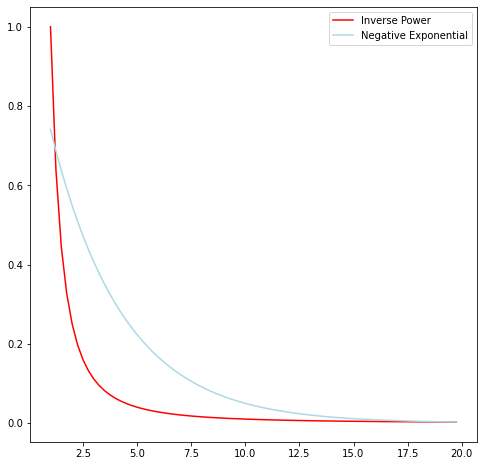

In [12]:
# Now let's consider some model tweaks.
# Starting with distance decay.
# Let's graph the distance decay parameters to get a feel for how they work.
xs = np.arange(1.0,20.0,0.25)
# inverse square power
y_inv_power = np.power(xs,-2)
# negative exponential, beta = 0.3
y_neg_exp_point3 = np.exp(-0.3*xs)

# Now a plot.
f, ax = plt.subplots(figsize=(8,8))
ax.plot(xs,y_inv_power, label = "Inverse Power", color = "red")
ax.plot(xs,y_neg_exp_point3, label = 'Negative Exponential', color = "lightblue")
ax.legend();

With these parameters, the inverse power function has a far more rapid distance decay effect than the negative exponential function. In real life, what this means is that if the observed interactions drop off very rapidly with distance, then they might be more likely to follow an inverse power law. This might be the case when looking at trips to the local convenience store by walking, for example. On the other hand, if the effect of distance is less severe (for example migration across the country for a new job) then the negative exponential funtion might be more appropriate.

There is no hard and fast rule as to which function to pick, it will just come down to which fits the data better…

As [Taylor Oshan points out in his excellent Primer](http://openjournals.wu.ac.at/region/paper_175/175.html) what this means in our Poisson regression model is that we simply substitute $-\beta \ln d_{ij}$ for $-\beta d_{ij}$ in our model:

In [13]:
# Run a doubly constrained SIM with a negative exponential cost function.
doubsim_form = "Total ~ Orig + Dest + Dist -1"
doubsim1 = smf.glm(formula=doubsim_form, data = cdatasub, family = sm.families.Poisson()).fit()
print(doubsim1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                   42
Model:                            GLM   Df Residuals:                       28
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1956.8
Date:                Fri, 03 Feb 2023   Deviance:                       3599.1
Time:                        09:59:46   Pearson chi2:                 3.42e+03
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Orig[Barking and Dag

In [14]:
cdatasub["doubsimfitted1"] = np.round(doubsim1.mu,0)

In [15]:
CalcRSqaured(cdatasub["Total"],cdatasub["doubsimfitted1"])

0.9835321475412175

In [16]:

CalcRMSE(cdatasub["Total"],cdatasub["doubsimfitted1"])

423.361

So we can see that using a negative exponential in our model actually improves the fit and reduces the RMSE score.

### 4.1.2 Bunging some more variables in

Yes, the nice thing about doing all of this in a regression modelling framework is that we can just keep adding predictor variables into the mix and seeing whether they have an effect.

You can't add origin or destination specific predictors into a doubly constrained model like this (To see why see the paper by [Flowerdew and Lovett 1988](https://onlinelibrary.wiley.com/doi/pdf/10.1111/j.1538-4632.1988.tb00184.x)) however, you could add some interaction predictors. For example, instead of modelling total flows, we could try and model motorbike commuters using information on car and underground commuters:

In [17]:
KitchenSinkForm = "Motobike ~ Orig + Dest + Dist +CarDrive +Underground -1"

KitchenSinkSim = smf.glm(formula=KitchenSinkForm, data = cdatasub, family = sm.families.Poisson()).fit()
print(KitchenSinkSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Motobike   No. Observations:                   42
Model:                            GLM   Df Residuals:                       26
Model Family:                 Poisson   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -121.73
Date:                Fri, 03 Feb 2023   Deviance:                       107.05
Time:                        09:59:46   Pearson chi2:                     89.3
No. Iterations:                    25   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Orig[Barking and Dag

So now it gets guite interesting. Some of the dummy/constraint origins become statistically insignificant when car and tube commuters are added into the mix.

How can we interpret this?

Well, the kind of things that might influence commuting by motorbike patterns (lack of access to public transport, distance from workplace etc.) that also influence travel to work by car, aren’t applicable to centrally-located Camden with lots of public transport links. Camden is just a proxy for these factors (being centrally-located Camden with lots of public transport links), but of-course doesn’t capture the subtle variation in access to public transport and distance that car travel does. Camden’s influence is [confounded](https://en.wikipedia.org/wiki/Confounding) by these better explanatory variables and becomes insignificant.

The parameter values give an indication of exactly how much of a change in commuting flows by motorcycle you might expect either for beginning or ended in a borough or for a one person change in people travelling by Car or Tube.

If you would like some more useful ifnromation on how to interpret the parameters (logged or otherwise) that emerge from a Poisson Regression model, again, [Taylot Oshan's primer](http://openjournals.wu.ac.at/region/paper_175/175.html) is an excellent place to turn.

## From Poisson Regression back to Entropy

As with the earlier models, I have shown you how you can plug the parameter estimates back into Wilson’s entropy maximising multiplicative models in order to generate estimates and tweak things still further.

If you remember from Equations 11 and 12 above, the key to the doubly constrained models is the $A_i$ and $B_j$ balancing factors and as they rely on each other, they need to be calculated iteratively. We can do this using [Senior’s algorthim](http://journals.sagepub.com/doi/abs/10.1177/030913257900300218) also mentioned earlier.

Here is the code as provided by [Dan Lewis](https://github.com/danlewis85/UCL_CASA_Urban_Simulation/blob/master/Constrained%20SIM.ipynb) who in a departure from Dennet rewrites the algorithm as a function, which can then be called subject to the required parameters. In order for it to work it requires:

- pd - a pandas dataframe of origin-destination pairwise flows and associated data.
- orig_field - the name of the dataframe field in pd that uniquely labels origin zones.
- dest_field - the name of the dataframe field in pd that uniquely labels destination zones.
- Oi_field - the name of the dataframe field that stores total flows from a given origin $i$
- Dj_field - the name of the dataframe field that stores total flows to a given destination $j$
- cij_field - the name of the dataframe field that stores the pairwise cost (e.g. distance) between $i$ and $j$
- beta - a constant for the beta parameter you wish to use in the model
- cost_function - a string representing the cost function, either 'power' or 'exponential'
- Ainame - What you want to call the new field in pd that will hold $A_{i}$ values, defaults to "Ai_new"
- Bjname - What you want to call the new field in pd that will hold $B_{j}$ values, defaults to "Bj_new"
- converge - A threshold value at which a model can be said to have converged, the default of 0.001 seems to work fine.

In [18]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(cdatasub.groupby(["OrigCodeNew"])["Total"].agg(np.sum))
O_i.rename(columns={"Total":"O_i"}, inplace = True)
cdatasub = cdatasub.merge(O_i, on = "OrigCodeNew", how = "left" )

D_j = pd.DataFrame(cdatasub.groupby(["DestCodeNew"])["Total"].agg(np.sum))
D_j.rename(columns={"Total":"D_j"}, inplace = True)
cdatasub = cdatasub.merge(D_j, on = "DestCodeNew", how = "left" )

In [19]:

# Here is the entropy maximising approach for a known beta.
# Plug in the required values in this function to solve.

def balance_doubly_constrained(pd, orig_field, dest_field, Oi_field, Dj_field, cij_field, beta, 
                               cost_function, Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001):
    # Define some variables
    Oi = pd[[orig_field, Oi_field]]
    Dj = pd[[dest_field,Dj_field]]    
    if cost_function.lower() in ['power','pow']:
        beta_cij = np.exp(beta * np.log(pd[cij_field]))
    elif cost_function.lower() in ['exponential','exp']:
        beta_cij = np.exp(beta * pd[cij_field])
    else:
        return "Cost function not specified properly, use 'exp' or 'pow'"
    
    # Create some helper variables
    cnvg = 1
    iteration = 0
    # Now iteratively rebalance the Ai and Bj terms until convergence
    while cnvg > converge:
        if iteration == 0:
            # This first condition sets starting values for Ai and Bj
            # NB sets starting value of Ai assuming Bj is a vector of 1s.
            # We've already established beta_cij with the appropriate cost function, so...
            Oi = Oi.assign(Ai = Dj[Dj_field] * beta_cij)
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Now set up Bjs using starting values of Ai
            Dj = Dj.assign(Bj = Oi['Ai_old'] * Oi[Oi_field] * beta_cij)
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Increment loop
            iteration += 1
        else:
            # This bit is the iterated bit of the loop which refines the values of Ai and Bj
            # First Ai
            Oi['Ai'] = Dj['Bj_old'] * Dj[Dj_field] * beta_cij
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Drop temporary Ai
            Oi.drop('Ai', axis=1, inplace=True)
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True)
            # Calculate the difference between old and new Ais
            Oi['diff'] = np.absolute((Oi['Ai_old'] - Oi['Ai'])/Oi['Ai_old'])
            # Set new Ais to Ai_old
            Oi['Ai_old'] = Oi['Ai']
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Then Bj
            Dj['Bj'] = Oi['Ai_old'] * Oi[Oi_field] * beta_cij
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Drop temporary Bj
            Dj.drop('Bj', axis=1, inplace=True)
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True)
            # Calculate the difference between old and new Bjs
            Dj['diff'] = np.absolute((Dj['Bj_old'] - Dj['Bj'])/Dj['Bj_old'])
            # Set new Bjs to Bj_old
            Dj['Bj_old'] = Dj['Bj']
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Assign higher sum difference from Ai or Bj to cnvg
            cnvg = np.maximum(Oi['diff'].sum(),Dj['diff'].sum())
            
            # Print and increment loop
            print("Iteration:", iteration)
            iteration += 1

    # When the while loop finishes add the computed Ai_old and Bj_old to the dataframe and return
    pd[Ai_name] = Oi['Ai_old']
    pd[Bj_name] = Dj['Bj_old']
    return pd


Using the function above we can calculate $A_{i}$ and $B_{j}$ for the previous Poisson model by plugging in the estimate of beta that we generated.

In [20]:

# Use the beta we got from the inverse power model
beta = -doubSim.params[-1]
# Get the balancing factors.
cdatasub = balance_doubly_constrained(cdatasub,'OrigCodeNew','DestCodeNew','O_i','D_j','Dist',-beta,'power')

# Now predict the model again using the new Ai and Dj fields.
cdatasub['SIM_est_pow'] = np.round(cdatasub['O_i'] * cdatasub['Ai_new'] * cdatasub['D_j'] * cdatasub['Bj_new'] * 
                                   np.exp(np.log(cdatasub['Dist'])*-beta))
# Check out the matrix
pd.pivot_table(cdatasub,values='SIM_est_pow',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8


Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,0,309,849,135,420,969,2993,5675.0
Barnet,23,0,72,5533,194,12970,6669,25461.0
Bexley,500,561,0,303,4454,1991,6877,14686.0
Brent,10,5275,37,0,125,8885,4176,18508.0
Bromley,134,818,2406,553,0,3127,10294,17332.0
Camden,6,1140,22,819,65,0,9716,11768.0
City of London,1,20,3,13,7,328,0,372.0
All,674,8123,3389,7356,5265,28270,40725,93802.0


In [21]:
# Use the beta we got from the negative exponential model
beta = -doubsim1.params[-1]
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
cdatasub = balance_doubly_constrained(cdatasub,'OrigCodeNew','DestCodeNew','O_i','D_j','Dist',-beta,'exponential','Ai_exp','Bj_exp')

# Now predict the model again using the new Ai and Dj fields.
cdatasub['SIM_est_exp'] = np.round(cdatasub['O_i'] * cdatasub['Ai_exp'] * cdatasub['D_j'] * cdatasub['Bj_exp'] * 
                                   np.exp(cdatasub['Dist']*-beta))
# Check out the matrix
pd.pivot_table(cdatasub,values='SIM_est_exp',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,0,261,713,98,387,1110,3106,5675.0
Barnet,17,0,31,5274,66,13108,6966,25462.0
Bexley,490,324,0,178,4664,1986,7043,14685.0
Brent,6,5052,16,0,57,8719,4658,18508.0
Bromley,148,392,2597,353,0,3057,10784,17331.0
Camden,11,2054,29,1426,81,0,8168,11769.0
City of London,1,39,4,27,10,290,0,371.0
All,673,8122,3390,7356,5265,28270,40725,93801.0


## 5. Conclusions, further notes and ideas for additional activities
Hopefully you have now seen how it is extremely straight-forward to run and calibrate Wilson’s full family of Spatial Interaction Models in Python using GLM and Poisson Regression.

### 5.1 Some Further Notes
Now might be the time to mention that despite everything I’ve shown you, there has been some discussion in the literature as to whether the Poisson Model is actually a misspecification, especially for modelling migration flows. If you have the stomach for it, [this paper by Congdon goes into a lot of detail.](http://journals.sagepub.com/doi/abs/10.1068/a251481)

The issue is a thing called ‘overdispersion’ which, translated, essentially relates to the model not being able to capture all of the things that could be explaining the flows in the independent variables that are supplied to the model. The details are tedious and only really intelligible to those with a statistics background. If you want a starter, [try here](https://en.wikipedia.org/wiki/Overdispersion), but in practical terms, we can get around this problem by fitting a very similar sort of regression model called the negative binomial regression model.

If you wish, you can read up and experiment with this model - you can fit it in exactly the same way as the poisson glm model but using: family = sm.families.NegativeBinomial(alpha) when you call the statsmodel glm function. The negative binomial model has an extra parameter - alpha - in the model for overdispersion with a default of 1. If you do try this, you will almost certainly discover that your results barely change - but hell, you might keep a pedantic reviewer at bay if you submit this to a journal (not that I’m speaking from experience or anything).

### And some more comments

Another thing to note is that the example we used here had quite neat data. You will almost certainly run into problems if you have sparse data or predictors with 0s in them. If this happens, then you might need to either drop some rows in your data (if populated with 0s) or substitute 0s for very small numbers, much less than 1, but greater than 0 (this is because you can’t take the log of 0). [Taylor Oshan's SpInt](http://openjournals.wu.ac.at/region/paper_175/175.html) implementation in Python uses a special Poisson regression approach that better handles sparse data structures.

And another thing to note is that our flow data and our predictors were all in and around the same order or magnitude. If you suddenly get data that (such as population masses at origins and destinations) that are an order of magnitude different (i.e. populations about ten times larger in different locations) then the model estimates might be biased. Fortunately, there are packages available to help us with these problems as well.

### 5.2 Further Activities
1. Testing these models out on the whole of London and for different years
    - You’ve been playing around with just a small 7 borough sample, why not try the full London system. +You can also try and download some similar data from the 2011 Census from [Wicid](http://wicid.ukdataservice.ac.uk/) - see if using Oi and Dj totals and the parameters you calibrated on the 2001 data, whether you can get reasonable estimates of the 2011 flows. +How have the model parameters changed between 2001 and 2011 - what does this mean
2. Visualising your flow estimates
    - try using the methods  last practical to visualise some of your flow estimates or flow residuals…

## Challenge to complete

The challenge to complete is to run every possible model (unconstrained, production constrained, attraction constrained and doubly constrained) with each distance decay function (power, exponential) on the total dataset and to extract each models paramaters, along with each models performance metrics ($R2$, $RMSE$). For this, you will need to go back to the original workshop to be able to extract the full `cdata` dataset which will be used here (push the data to a csv and then read it in here).

At this point you should be able to cobble togther rather basic code to implement each model and then extract their performance and paramaters. To this end, you will not be given any comment hints. You can do this manually or you could create a loop to iterate over each model to save on code, this is up to you. Good luck!

## <u>Data<u>

What I have done here is gone into practical 2 on unconstrained models and exported the cleaned dataset that is then used to subset the boroughs that we have looked at over the last several weeks because, here, we are interested in the entire dataset 

In [22]:
cdata_clean = pd.read_csv("cdata_clean.csv")

In [23]:
cdata_clean2 = cdata_clean.drop(columns="Unnamed: 0")

In [24]:
cdata_clean2.head(5)

,Orig,OrigCode,Dest,DestCode,Total,WorksFromHome,Underground,Train,Bus,Taxi,...,Other,OrigCodeNew,DestCodeNew,Oi1_origpop,Oi2_origsal,Dj1_destpop,Dj2_destsal,TotalNoIntra,offset,Dist
0,City of London,00AA,City of London,00AA,2059,432,120,53,50,31,...,41,E09000001,E09000001,12000,38300,12000,38300,0,1.000000e-10,0.000000
1,City of London,00AA,Barking and Dagenham,00AB,6,0,3,3,0,0,...,0,E09000001,E09000002,12000,38300,56000,16200,6,0.000000e+00,15995.228544
2,City of London,00AA,Barnet,00AC,14,0,11,0,0,0,...,0,E09000001,E09000003,12000,38300,159000,18700,14,0.000000e+00,13935.670948
3,City of London,00AA,Bexley,00AD,0,0,0,0,0,0,...,0,E09000001,E09000004,12000,38300,112000,18300,0,0.000000e+00,17359.908686
4,City of London,00AA,Brent,00AE,16,0,10,0,3,0,...,0,E09000001,E09000005,12000,38300,127000,16500,16,0.000000e+00,13119.797202


In [25]:
# removing the intra-borough flows
cdata3 = cdata_clean2[cdata_clean["OrigCode"] != cdata_clean["DestCode"]]

# re-order so that OrigCodeNEw, DestCodeNew and TotalNoIntra are the first three columns
beg = ["OrigCodeNew", "DestCodeNew", "TotalNoIntra"] 
cols = beg + [col for col in cdata3.columns.tolist() if col not in beg]
#re index the columns
cdata3 = cdata3.reindex(columns = cols)

In [26]:
cdata3.columns

Index(['OrigCodeNew', 'DestCodeNew', 'TotalNoIntra', 'Orig', 'OrigCode',
       'Dest', 'DestCode', 'Total', 'WorksFromHome', 'Underground', 'Train',
       'Bus', 'Taxi', 'CarDrive', 'CarPass', 'Motobike', 'Bicycle', 'Walk',
       'Other', 'Oi1_origpop', 'Oi2_origsal', 'Dj1_destpop', 'Dj2_destsal',
       'offset', 'Dist'],
      dtype='object')

In [27]:
cdatamat = cdata3.pivot_table(values ="TotalNoIntra", index="Orig", columns = "Dest",
                             aggfunc=np.sum, margins=True)

**As Adam suggests, we can work with these models if 'we simply substitute $-\beta \ln d_{ij}$ for $-\beta d_{ij}$ in our model.'**

## <u>Unconstrained<u>
    
\begin{equation}
\lambda_{ij} = \exp (K + \alpha \ln O_i + \gamma \ln D_j - \beta \ln d_{ij})
\end{equation}

In [28]:
#take the variables and produce logarithms of them which we will use in various formulas below
x_variables = ["Oi1_origpop", "Dj2_destsal", "Dist"]
log_x_vars = []
for x in x_variables:
    cdata3[f"log_{x}"] = np.log(cdata3[x])
    log_x_vars.append(f"log_{x}")

#### Power

In [29]:
#create the formula
formula = 'Total ~ log_Oi1_origpop + log_Dj2_destsal + log_Dist'

#run the regression
uncosim = smf.glm(formula = formula, 
                  data=cdata3, 
                  family=sm.families.Poisson()).fit()

In [30]:
print(uncosim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                 1056
Model:                            GLM   Df Residuals:                     1052
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -7.1207e+05
Date:                Fri, 03 Feb 2023   Deviance:                   1.4157e+06
Time:                        09:59:49   Pearson chi2:                 1.95e+06
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -12.4115      0.047   -2

In [31]:
#print out the new values
K = uncosim.params[0]
alpha = uncosim.params[1]
gamma = uncosim.params[2]
beta = -uncosim.params[3]
print(K)
print(alpha)
print(gamma)
print(beta)

-12.411461418745318
1.6195066838490195
1.544097315605799
1.5002394901704164


In [32]:
cdata3["unconstrained_est1"] = np.exp(K+ 
                                      alpha*cdata3["log_Oi1_origpop"]+ 
                                      gamma*cdata3["log_Dj2_destsal"] - 
                                      beta*cdata3["log_Dist"])

cdatamat1 = cdata3.pivot_table(values ="unconstrained_est1", index="Orig", columns = "Dest",
                             aggfunc=np.sum, margins=True)

In [33]:
CalcRSqaured(cdata3["Total"], cdata3["unconstrained_est1"])

0.38579894200715287

In [34]:
CalcRMSE(cdata3["Total"], cdata3["unconstrained_est1"])

2330.264

#### Exponential

In [35]:
#create the formula
formula = 'Total ~ log_Oi1_origpop + log_Dj2_destsal + Dist -1'

#run the regression
uncosim_exp = smf.glm(formula = formula, 
                  data=cdata3, 
                  family=sm.families.Poisson()).fit()

In [36]:
print(uncosim_exp.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                 1056
Model:                            GLM   Df Residuals:                     1053
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -7.7849e+05
Date:                Fri, 03 Feb 2023   Deviance:                   1.5486e+06
Time:                        09:59:49   Pearson chi2:                 2.32e+06
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_Oi1_origpop     0.5627      0.002    3

In [37]:
#print out the new values
# K = uncosim_exp.params[0]
alpha = uncosim_exp.params[0]
gamma = uncosim_exp.params[1]
beta = -uncosim_exp.params[2]
# print(K)
print(alpha)
print(gamma)
print(beta)

0.5627211648722226
0.30304797154994567
0.00014702146713836347


 we simply substitute $-\beta \ln d_{ij}$ for $-\beta d_{ij}$ in our model in order to use the **negative exponential decay**

In [38]:
cdata3["unconstrained_est2"] = np.exp(
                                      alpha*cdata3["log_Oi1_origpop"]+ 
                                      gamma*cdata3["log_Dj2_destsal"] - 
                                      beta*cdata3["Dist"])
#I could add the K value back in here

In [39]:
cdatamat2 = cdata3.pivot_table(values ="unconstrained_est2", index="Orig", columns = "Dest",
                             aggfunc=np.sum, margins=True)

In [40]:
CalcRSqaured(cdata3["Total"], cdata3["unconstrained_est2"])

0.41750183920545336

In [41]:
CalcRMSE(cdata3["Total"], cdata3["unconstrained_est2"])

2208.257

## <u>Production Constrained<u>

\begin{equation}
\lambda_{ij} = \exp (\alpha_i + \gamma \ln D_j - \beta \ln d_{ij})
\end{equation}

#### Power

In [42]:
#create the formula. This is origin constrained and we want to find Ai.
formula = 'Total ~ OrigCodeNew + log_Dj2_destsal + log_Dist-1'
#run the simulation
prodSim = smf.glm(formula = formula, data=cdata3, family=sm.families.Poisson()).fit()
#summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                 1056
Model:                            GLM   Df Residuals:                     1021
Model Family:                 Poisson   Df Model:                           34
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -6.0178e+05
Date:                Fri, 03 Feb 2023   Deviance:                   1.1951e+06
Time:                        09:59:50   Pearson chi2:                 1.63e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
OrigCodeNew[E09000001]     3

In [43]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them
O_i = pd.DataFrame(cdata3.groupby(["OrigCodeNew"])["Total"].agg(np.sum))
O_i.rename(columns={"Total":"O_i"}, inplace = True)
cdata3 = cdata3.merge(O_i, on = "OrigCodeNew", how = "left" )

D_j = pd.DataFrame(cdata3.groupby(["DestCodeNew"])["Total"].agg(np.sum))
D_j.rename(columns={"Total":"D_j"}, inplace = True)
cdata3 = cdata3.merge(D_j, on = "DestCodeNew", how = "left" )

In [44]:
# pulling out the parameter values
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(OrigCodeNew)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
#then once you have done this you can join them back into the dataframes
cdata3 = cdata3.merge(coefs, left_on="OrigCodeNew", right_on="coef", how = "left")
cdata3.drop(columns = ["coef"], inplace = True)
cdata3.head(2)

/tmp/ipykernel_47572/2243277098.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,OrigCodeNew,DestCodeNew,TotalNoIntra,Orig,OrigCode,Dest,DestCode,Total,WorksFromHome,Underground,...,offset,Dist,log_Oi1_origpop,log_Dj2_destsal,log_Dist,unconstrained_est1,unconstrained_est2,O_i,D_j,alpha_i
0,E09000001,E09000002,6,City of London,00AA,Barking and Dagenham,00AB,6,0,3,...,0.0,15995.228544,9.392662,9.692767,9.680046,25.641323,354.667570,2062,18313,3.670674
1,E09000001,E09000003,14,City of London,00AA,Barnet,00AC,14,0,11,...,0.0,13935.670948,9.392662,9.836279,9.542207,39.353824,501.433608,2062,30744,3.670674


In [45]:
alpha_i = prodSim.params[0:33]
gamma = prodSim.params[33]
beta = -prodSim.params[34]

In [46]:
alpha_i

OrigCodeNew[E09000001]    3.670674
OrigCodeNew[E09000002]    7.576468
OrigCodeNew[E09000003]    8.157779
OrigCodeNew[E09000004]    8.106262
OrigCodeNew[E09000005]    7.771451
OrigCodeNew[E09000006]    8.568050
OrigCodeNew[E09000007]    6.772284
OrigCodeNew[E09000008]    8.261074
OrigCodeNew[E09000009]    8.069452
OrigCodeNew[E09000010]    8.106730
OrigCodeNew[E09000011]    7.607184
OrigCodeNew[E09000012]    6.794190
OrigCodeNew[E09000013]    6.598514
OrigCodeNew[E09000014]    7.461410
OrigCodeNew[E09000015]    8.045194
OrigCodeNew[E09000016]    8.350419
OrigCodeNew[E09000017]    8.025859
OrigCodeNew[E09000018]    7.640080
OrigCodeNew[E09000019]    6.569770
OrigCodeNew[E09000020]    6.391581
OrigCodeNew[E09000021]    7.337238
OrigCodeNew[E09000022]    7.582386
OrigCodeNew[E09000023]    7.774806
OrigCodeNew[E09000024]    7.498179
OrigCodeNew[E09000025]    7.396197
OrigCodeNew[E09000026]    8.019873
OrigCodeNew[E09000027]    7.518191
OrigCodeNew[E09000028]    7.125628
OrigCodeNew[E0900002

In [47]:
gamma

1.715880898862336

\begin{equation}
\lambda_{ij} = \exp (\alpha_i + \gamma \ln D_j - \beta \ln d_{ij})
\end{equation}

In [48]:
cdata3["prodsimest1"] = np.exp(cdata3["alpha_i"]+gamma*cdata3["log_Dj2_destsal"] 
                                 - beta*cdata3["log_Dist"])

In [49]:
CalcRSqaured(cdata3["Total"], cdata3["prodsimest1"])

0.4412708793499413

In [50]:
CalcRMSE(cdata3["Total"], cdata3["prodsimest1"])

2205.134

#### Exponential

In [51]:
#create the formula. This is origin constrained and we want to find Ai.
formula = 'Total ~ OrigCodeNew + log_Dj2_destsal + Dist -1'

prodSim_exp = smf.glm(formula = formula, data=cdata3, family=sm.families.Poisson()).fit()

print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                 1056
Model:                            GLM   Df Residuals:                     1021
Model Family:                 Poisson   Df Model:                           34
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -6.0178e+05
Date:                Fri, 03 Feb 2023   Deviance:                   1.1951e+06
Time:                        09:59:51   Pearson chi2:                 1.63e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
OrigCodeNew[E09000001]     3

In [52]:
cdata3.head(5)

,OrigCodeNew,DestCodeNew,TotalNoIntra,Orig,OrigCode,Dest,DestCode,Total,WorksFromHome,Underground,...,Dist,log_Oi1_origpop,log_Dj2_destsal,log_Dist,unconstrained_est1,unconstrained_est2,O_i,D_j,alpha_i,prodsimest1
0,E09000001,E09000002,6,City of London,00AA,Barking and Dagenham,00AB,6,0,3,...,15995.228544,9.392662,9.692767,9.680046,25.641323,354.667570,2062,18313,3.670674,15.234278
1,E09000001,E09000003,14,City of London,00AA,Barnet,00AC,14,0,11,...,13935.670948,9.392662,9.836279,9.542207,39.353824,501.433608,2062,30744,3.670674,25.030875
2,E09000001,E09000004,0,City of London,00AA,Bexley,00AD,0,0,0,...,17359.908686,9.392662,9.814656,9.761919,27.373787,301.111947,2062,11740,3.670674,16.183898
3,E09000001,E09000005,16,City of London,00AA,Brent,00AE,16,0,10,...,13119.797202,9.392662,9.711116,9.481878,35.510831,544.295191,2062,36217,3.670674,22.531224
4,E09000001,E09000006,0,City of London,00AA,Bromley,00AF,0,0,0,...,18740.822957,9.392662,9.857444,9.838459,26.071015,248.992971,2062,24934,3.670674,15.156633


In [53]:
# extracting parametre values
coefs = pd.DataFrame(prodSim_exp.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(OrigCodeNew)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
    
#join them back into the dataframe
cdata3 = cdata3.merge(coefs, left_on="OrigCodeNew", right_on="coef", how = "left")
cdata3.drop(columns = ["coef"], inplace = True)
cdata3.head(2)

/tmp/ipykernel_47572/314045372.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,OrigCodeNew,DestCodeNew,TotalNoIntra,Orig,OrigCode,Dest,DestCode,Total,WorksFromHome,Underground,...,log_Oi1_origpop,log_Dj2_destsal,log_Dist,unconstrained_est1,unconstrained_est2,O_i,D_j,alpha_i_x,prodsimest1,alpha_i_y
0,E09000001,E09000002,6,City of London,00AA,Barking and Dagenham,00AB,6,0,3,...,9.392662,9.692767,9.680046,25.641323,354.667570,2062,18313,3.670674,15.234278,-11.197198
1,E09000001,E09000003,14,City of London,00AA,Barnet,00AC,14,0,11,...,9.392662,9.836279,9.542207,39.353824,501.433608,2062,30744,3.670674,25.030875,-11.197198


In [54]:
alpha_i = prodSim_exp.params[0:33]
gamma = prodSim_exp.params[33]
beta = -prodSim_exp.params[34]

In [55]:
alpha_i

OrigCodeNew[E09000001]   -11.197198
OrigCodeNew[E09000002]    -7.372036
OrigCodeNew[E09000003]    -6.898958
OrigCodeNew[E09000004]    -6.817618
OrigCodeNew[E09000005]    -7.293246
OrigCodeNew[E09000006]    -6.324992
OrigCodeNew[E09000007]    -8.071913
OrigCodeNew[E09000008]    -6.701026
OrigCodeNew[E09000009]    -6.972107
OrigCodeNew[E09000010]    -6.871215
OrigCodeNew[E09000011]    -7.420143
OrigCodeNew[E09000012]    -8.035874
OrigCodeNew[E09000013]    -7.987058
OrigCodeNew[E09000014]    -7.536032
OrigCodeNew[E09000015]    -6.908830
OrigCodeNew[E09000016]    -6.405309
OrigCodeNew[E09000017]    -6.832941
OrigCodeNew[E09000018]    -7.279938
OrigCodeNew[E09000019]    -8.158177
OrigCodeNew[E09000020]    -8.177297
OrigCodeNew[E09000021]    -7.630640
OrigCodeNew[E09000022]    -7.399811
OrigCodeNew[E09000023]    -7.269714
OrigCodeNew[E09000024]    -7.494503
OrigCodeNew[E09000025]    -7.635642
OrigCodeNew[E09000026]    -6.966467
OrigCodeNew[E09000027]    -7.473791
OrigCodeNew[E09000028]    -7

In [56]:
gamma

1.730895499507155

\begin{equation}
\lambda_{ij} = \exp (\alpha_i + \gamma \ln D_j - \beta \ln d_{ij})
\end{equation}

In [57]:
cdata3["prodsimest2"] = np.exp(cdata3["alpha_i_y"]+gamma*cdata3["log_Dj2_destsal"] 
                                 - beta*cdata3["Dist"])
# Here, I use alpha_i_y because the df cdata3 had the alpha values from the power decay so it had two versions of alpha.
# this way, it is modelling based on the correct parametres that were taken from the model and added to the df.

In [58]:
CalcRSqaured(cdata3["Total"], cdata3["prodsimest2"])

0.4912656721540798

In [59]:
CalcRMSE(cdata3["Total"], cdata3["prodsimest2"])

2068.943

## <u>Attraction Constrained<u>
    
\begin{equation}
\lambda_{ij} \exp (\alpha \ln O_i + \gamma_i - \beta \ln d_{ij})
\end{equation}

#### Power

In [60]:
#create the formula, the Destination constant and we want to find Bj
attr_form = 'Total ~ DestCodeNew + log_Oi1_origpop + log_Dist-1'
#run the simulation
attrSim = smf.glm(formula = attr_form, data=cdata3, family=sm.families.Poisson()).fit()
#summary
print(attrSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                 1056
Model:                            GLM   Df Residuals:                     1021
Model Family:                 Poisson   Df Model:                           34
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.2293e+05
Date:                Fri, 03 Feb 2023   Deviance:                   6.3745e+05
Time:                        09:59:52   Pearson chi2:                 7.52e+05
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
DestCodeNew[E09000001]     2

We can examine how the constraints hold for destinations this time:

In [61]:
#get the predictions
predictions = attrSim.get_prediction(cdata3[["DestCodeNew", "log_Oi1_origpop", "log_Dist"]])
predictions_summary_frame = predictions.summary_frame()
cdata3["attrsimFitted"] = round(predictions_summary_frame["mean"])

In [62]:
alpha_i = attrSim.params[0:33]
gamma = attrSim.params[33]
beta = -attrSim.params[34]

In [63]:
alpha_i

DestCodeNew[E09000001]    2.191932
DestCodeNew[E09000002]    0.387977
DestCodeNew[E09000003]    0.898694
DestCodeNew[E09000004]    0.142665
DestCodeNew[E09000005]    0.798361
DestCodeNew[E09000006]    0.993273
DestCodeNew[E09000007]    1.934041
DestCodeNew[E09000008]    1.032503
DestCodeNew[E09000009]    1.083033
DestCodeNew[E09000010]    0.534394
DestCodeNew[E09000011]    0.447782
DestCodeNew[E09000012]    0.639509
DestCodeNew[E09000013]    0.970924
DestCodeNew[E09000014]    0.459536
DestCodeNew[E09000015]    0.438657
DestCodeNew[E09000016]    0.584865
DestCodeNew[E09000017]    1.677196
DestCodeNew[E09000018]    1.104579
DestCodeNew[E09000019]    1.360471
DestCodeNew[E09000020]    0.896823
DestCodeNew[E09000021]    0.347087
DestCodeNew[E09000022]    1.106181
DestCodeNew[E09000023]    0.387208
DestCodeNew[E09000024]    0.408827
DestCodeNew[E09000025]    0.586412
DestCodeNew[E09000026]    0.605165
DestCodeNew[E09000027]    0.479578
DestCodeNew[E09000028]    1.341989
DestCodeNew[E0900002

In [64]:
gamma

1.660411148101104

In [65]:
CalcRSqaured(cdata3["Total"], cdata3["attrsimFitted"])

0.7135334741832099

In [66]:
CalcRMSE(cdata3["Total"], cdata3["attrsimFitted"])

1671.577

#### Exponential

In [67]:
#create the formula, the Destination constant and we want to find Bj
attr_form = 'Total ~ DestCodeNew + log_Oi1_origpop + Dist -1'

attrSim_exp = smf.glm(formula = attr_form, data=cdata3, family=sm.families.Poisson()).fit()

print(attrSim_exp.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                 1056
Model:                            GLM   Df Residuals:                     1021
Model Family:                 Poisson   Df Model:                           34
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.5503e+05
Date:                Fri, 03 Feb 2023   Deviance:                   5.0165e+05
Time:                        09:59:53   Pearson chi2:                 5.96e+05
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
DestCodeNew[E09000001]    -7

We can examine how the constraints hold for destinations this time:

In [68]:
#get the predictions
predictions_exp = attrSim_exp.get_prediction(cdata3[["DestCodeNew", "log_Oi1_origpop", "Dist"]])
predictions_summary_frame_exp = predictions_exp.summary_frame()
cdata3["attrsimFitted_exp"] = round(predictions_summary_frame_exp["mean"])

In [69]:
alpha_i = attrSim_exp.params[0:33]
gamma = attrSim_exp.params[33]
beta = -attrSim_exp.params[34]

In [70]:
alpha_i

DestCodeNew[E09000001]   -7.287766
DestCodeNew[E09000002]   -8.999856
DestCodeNew[E09000003]   -8.575710
DestCodeNew[E09000004]   -9.220852
DestCodeNew[E09000005]   -8.703452
DestCodeNew[E09000006]   -8.348601
DestCodeNew[E09000007]   -7.535901
DestCodeNew[E09000008]   -8.376727
DestCodeNew[E09000009]   -8.392224
DestCodeNew[E09000010]   -8.858474
DestCodeNew[E09000011]   -9.026125
DestCodeNew[E09000012]   -8.835132
DestCodeNew[E09000013]   -8.452045
DestCodeNew[E09000014]   -9.026629
DestCodeNew[E09000015]   -8.971220
DestCodeNew[E09000016]   -8.573640
DestCodeNew[E09000017]   -7.622915
DestCodeNew[E09000018]   -8.301671
DestCodeNew[E09000019]   -8.083121
DestCodeNew[E09000020]   -8.453647
DestCodeNew[E09000021]   -9.067310
DestCodeNew[E09000022]   -8.372637
DestCodeNew[E09000023]   -9.119525
DestCodeNew[E09000024]   -9.047439
DestCodeNew[E09000025]   -8.910073
DestCodeNew[E09000026]   -8.802316
DestCodeNew[E09000027]   -8.974687
DestCodeNew[E09000028]   -8.137038
DestCodeNew[E0900002

In [71]:
gamma

1.5223806282025436

In [72]:
CalcRSqaured(cdata3["Total"], cdata3["attrsimFitted_exp"])

0.8088582414613606

In [73]:
CalcRMSE(cdata3["Total"], cdata3["attrsimFitted_exp"])

1305.961

## <u>Doubly Constrained<u>
    
\begin{equation}
\lambda_{ij} = \exp (\alpha_i + \gamma_j -\beta \ln d_{ij})
\end{equation}

#### Power

In [74]:
#create the formula.
dbl_form = 'Total ~ Dest + Orig + log_Dist -1'

#run a doubly constrained simulation based on the power decay
doubSim = smf.glm(formula = dbl_form, data=cdata3, family=sm.families.Poisson()).fit()

# the summary of the regression models
print(doubSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                 1056
Model:                            GLM   Df Residuals:                      990
Model Family:                 Poisson   Df Model:                           65
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.6598e+05
Date:                Fri, 03 Feb 2023   Deviance:                   3.2354e+05
Time:                        09:59:55   Pearson chi2:                 3.45e+05
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Dest[Barking

In [75]:
beta = -doubSim.params[-1]
print(beta)

1.9273627178779607


In [76]:
cdata3["doubsimfitted"] = np.round(doubSim.mu)

In [77]:
CalcRSqaured(cdata3["Total"],cdata3["doubsimfitted"])

0.8548780059792511

In [78]:
CalcRMSE(cdata3["Total"],cdata3["doubsimfitted"])

1135.671

In [79]:
# Get the balancing factors.
cdata3 = balance_doubly_constrained(cdata3,'OrigCodeNew','DestCodeNew','O_i','D_j','Dist',-beta,'power')

# Now predict the model again using the new Ai and Dj fields.
cdata3['SIM_est_pow'] = np.round(cdata3['O_i'] * cdata3['Ai_new'] * cdata3['D_j'] * cdata3['Bj_new'] * 
                                   np.exp(np.log(cdata3['Dist'])*-beta))
# Check out the matrix
pd.pivot_table(cdata3,values='SIM_est_pow',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)
double_mat_pow = pd.pivot_table(cdata3,values='SIM_est_pow',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8


In [80]:
cdatamat - double_mat_pow

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,Croydon,Ealing,Enfield,...,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster,All
Orig,,,,,,,,,,,,,,,,,,,,,
Barking and Dagenham,NaN,-255.0,-1013.0,-125.0,-646.0,-416.0,-65.0,-314.0,-104.0,-112.0,...,1617.0,2275.0,-117.0,-390.0,-96.0,1018.0,233.0,-254.0,-828.0,1.0
Barnet,-119.0,NaN,-116.0,599.0,-280.0,-831.0,1457.0,-255.0,-498.0,1350.0,...,-94.0,-173.0,-236.0,434.0,-144.0,354.0,-182.0,-407.0,993.0,2.0
Bexley,-1561.0,-409.0,NaN,-288.0,1648.0,-68.0,1226.0,-480.0,-271.0,-360.0,...,-1632.0,-1041.0,-174.0,2076.0,-148.0,-1198.0,-344.0,-188.0,1444.0,2.0
Brent,-73.0,2363.0,-64.0,NaN,-195.0,-1823.0,-340.0,-161.0,398.0,-183.0,...,16.0,-100.0,-296.0,485.0,-128.0,334.0,-72.0,-474.0,-480.0,4.0
Bromley,-536.0,-537.0,1379.0,-463.0,NaN,305.0,2791.0,-753.0,-504.0,-414.0,...,-837.0,-588.0,-378.0,1678.0,-339.0,-652.0,-275.0,-428.0,3019.0,0.0
Camden,-21.0,693.0,-12.0,551.0,-50.0,NaN,2792.0,15.0,223.0,27.0,...,119.0,-34.0,60.0,1005.0,-7.0,1451.0,15.0,125.0,-6968.0,0.0
City of London,2.0,0.0,-3.0,3.0,-8.0,112.0,NaN,-6.0,-2.0,-3.0,...,-1.0,-8.0,1.0,-51.0,-1.0,3.0,6.0,-11.0,-129.0,0.0
Croydon,-214.0,-398.0,-192.0,-344.0,-194.0,86.0,69.0,NaN,-504.0,-241.0,...,-440.0,-310.0,-371.0,730.0,1729.0,-648.0,-173.0,1461.0,631.0,1.0
Ealing,-94.0,-863.0,-79.0,-1947.0,-268.0,-1429.0,671.0,-355.0,NaN,-265.0,...,-46.0,-140.0,-576.0,91.0,-255.0,102.0,-124.0,-830.0,-471.0,2.0


In [81]:
final_powflows = cdatamat - double_mat_pow

In [82]:
final_powflows.describe()

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,Croydon,Ealing,Enfield,...,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster,All
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,...,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,34.000000
mean,-0.060606,-0.060606,-0.060606,0.000000,0.181818,0.000000,0.060606,-0.060606,0.181818,0.000000,...,0.242424,0.060606,0.000000,0.060606,-0.121212,0.000000,0.121212,0.121212,-0.121212,0.352941
std,550.691948,663.570500,640.486238,884.812833,873.520301,1443.819219,3414.374375,535.255193,653.040555,478.020724,...,826.549493,624.851979,367.173665,1489.659628,365.891613,1296.185678,366.135371,518.629309,3034.188666,1.905055
min,-1561.000000,-863.000000,-1096.000000,-1947.000000,-972.000000,-3530.000000,-9178.000000,-753.000000,-1121.000000,-414.000000,...,-2488.000000,-1041.000000,-576.000000,-7091.000000,-339.000000,-3025.000000,-537.000000,-830.000000,-11910.000000,-2.000000
25%,-110.000000,-398.000000,-91.000000,-310.000000,-319.000000,-831.000000,-1184.000000,-282.000000,-326.000000,-202.000000,...,-125.000000,-165.000000,-193.000000,-171.000000,-140.000000,-537.000000,-153.000000,-407.000000,-824.000000,-1.000000
50%,-60.000000,-225.000000,-64.000000,-128.000000,-195.000000,0.000000,1.000000,-91.000000,-62.000000,-131.000000,...,-78.000000,-106.000000,-61.000000,91.000000,-85.000000,3.000000,-82.000000,-26.000000,367.000000,0.500000
75%,-1.000000,29.000000,-11.000000,156.000000,-50.000000,530.000000,1655.000000,32.000000,153.000000,-3.000000,...,19.000000,-13.000000,60.000000,622.000000,-2.000000,671.000000,15.000000,161.000000,2334.000000,1.750000
max,1933.000000,2363.000000,2839.000000,4142.000000,4092.000000,3442.000000,7887.000000,1721.000000,2678.000000,2013.000000,...,1981.000000,2275.000000,1090.000000,2076.000000,1729.000000,2509.000000,1432.000000,1461.000000,3068.000000,6.000000


#### Exponential

In [83]:
#run a doubly constrained simulation based on the negative exponential cost function
doubsim_form = "Total ~ Orig + Dest + Dist -1"
doubsim1 = smf.glm(formula=doubsim_form, data = cdata3, family = sm.families.Poisson()).fit()
print(doubsim1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                 1056
Model:                            GLM   Df Residuals:                      990
Model Family:                 Poisson   Df Model:                           65
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1154e+05
Date:                Fri, 03 Feb 2023   Deviance:                   2.1467e+05
Time:                        09:59:58   Pearson chi2:                 2.17e+05
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Orig[Barking

In [84]:
beta = -doubsim1.params[-1]
print(beta)

0.00018056432187175822


In [85]:
cdata3["doubsimfitted1"] = np.round(doubsim1.mu,0)

In [86]:
CalcRSqaured(cdata3["Total"],cdata3["doubsimfitted1"])

0.9097530610032607

In [87]:
CalcRMSE(cdata3["Total"],cdata3["doubsimfitted1"])

874.019

In [88]:
# Use the beta we got from the negative exponential model
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
cdata3 = balance_doubly_constrained(cdata3,'OrigCodeNew','DestCodeNew','O_i','D_j','Dist',-beta,'exponential','Ai_exp','Bj_exp')

# Now predict the model again using the new Ai and Dj fields.
cdata3['SIM_est_exp'] = np.round(cdata3['O_i'] * cdata3['Ai_exp'] * cdata3['D_j'] * cdata3['Bj_exp'] * 
                                   np.exp(cdata3['Dist']*-beta))
# Check out the matrix
pd.pivot_table(cdata3,values='SIM_est_exp',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)
double_mat_exp = pd.pivot_table(cdata3,values='SIM_est_exp',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11


In [89]:
cdatamat - double_mat_exp

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,Croydon,Ealing,Enfield,...,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster,All
Orig,,,,,,,,,,,,,,,,,,,,,
Barking and Dagenham,NaN,-49.0,-1225.0,55.0,-535.0,-146.0,-587.0,-89.0,117.0,-106.0,...,1458.0,2384.0,-7.0,-622.0,-8.0,146.0,-25.0,-80.0,-87.0,-3.0
Barnet,20.0,NaN,2.0,593.0,15.0,-1397.0,1523.0,58.0,-601.0,921.0,...,93.0,18.0,-99.0,711.0,-14.0,736.0,-152.0,-206.0,-121.0,1.0
Bexley,-1964.0,-47.0,NaN,9.0,330.0,699.0,765.0,-320.0,89.0,-128.0,...,-2266.0,-1232.0,13.0,1263.0,-21.0,-2286.0,-334.0,46.0,2898.0,-1.0
Brent,11.0,2428.0,10.0,NaN,8.0,-1716.0,-387.0,62.0,1453.0,-158.0,...,141.0,27.0,-377.0,587.0,-45.0,604.0,2.0,-528.0,-1258.0,1.0
Bromley,-402.0,-12.0,836.0,-17.0,NaN,1577.0,2660.0,-3654.0,62.0,-51.0,...,-873.0,-305.0,-118.0,-150.0,-694.0,-1044.0,-63.0,-523.0,4814.0,-1.0
Camden,-15.0,159.0,1.0,65.0,-17.0,NaN,1333.0,34.0,-77.0,-189.0,...,46.0,-60.0,-18.0,410.0,-11.0,783.0,-104.0,-221.0,-1205.0,2.0
City of London,2.0,-7.0,-4.0,-4.0,-9.0,81.0,NaN,-7.0,-5.0,-7.0,...,-7.0,-10.0,-1.0,-43.0,-1.0,74.0,1.0,-25.0,-83.0,0.0
Croydon,-32.0,29.0,-56.0,8.0,-1627.0,1032.0,290.0,NaN,-60.0,39.0,...,-228.0,-59.0,-381.0,-387.0,1218.0,-342.0,12.0,631.0,1261.0,0.0
Ealing,11.0,-928.0,18.0,-773.0,20.0,-1779.0,1296.0,-27.0,NaN,-70.0,...,133.0,26.0,-882.0,370.0,-145.0,632.0,11.0,-939.0,-1399.0,2.0


In [90]:
final_expflows = cdatamat - double_mat_exp

In [91]:
final_expflows.describe()

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,Croydon,Ealing,Enfield,...,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster,All
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,...,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.00000,33.000000,34.000000
mean,0.000000,-0.060606,0.060606,0.181818,0.060606,-0.060606,-0.060606,-0.060606,-0.242424,0.060606,...,-0.060606,-0.060606,-0.060606,0.242424,0.000000,0.000000,0.181818,0.00000,-0.060606,0.352941
std,527.717728,538.468542,739.998182,830.811330,772.914530,1095.698862,2737.640418,783.863028,518.817287,398.085492,...,777.919137,599.589857,510.920122,568.612073,349.537283,1162.844089,375.348876,735.04783,1694.554605,1.936607
min,-1964.000000,-928.000000,-2035.000000,-967.000000,-1627.000000,-2398.000000,-5524.000000,-3654.000000,-1541.000000,-872.000000,...,-2266.000000,-1232.000000,-882.000000,-1151.000000,-694.000000,-3140.000000,-733.000000,-959.00000,-3470.000000,-4.000000
25%,-26.000000,-177.000000,-33.000000,-237.000000,-143.000000,-742.000000,-1616.000000,-55.000000,-92.000000,-105.000000,...,-55.000000,-119.000000,-118.000000,-387.000000,-60.000000,-353.000000,-90.000000,-398.00000,-1205.000000,-1.000000
50%,2.000000,-47.000000,-3.000000,-6.000000,-25.000000,120.000000,290.000000,3.000000,89.000000,-64.000000,...,-1.000000,-24.000000,-7.000000,4.000000,-24.000000,326.000000,-31.000000,-84.00000,89.000000,0.500000
75%,24.000000,-1.000000,13.000000,55.000000,8.000000,699.000000,1523.000000,62.000000,166.000000,2.000000,...,93.000000,9.000000,36.000000,370.000000,-1.000000,698.000000,3.000000,46.00000,1018.000000,1.000000
max,1467.000000,2428.000000,3222.000000,4236.000000,3723.000000,2276.000000,5496.000000,1813.000000,1453.000000,1767.000000,...,2040.000000,2384.000000,2270.000000,1263.000000,1264.000000,1934.000000,1599.000000,2585.00000,4814.000000,6.000000


Think about: 
- What do these paramaters mean?

The parametres vary per model but each beta tells us the severity of the "cost" function. The doubly constrained power decay beta seems to be the largest. But this makes sense (to me) because we are fitting the model using more of our data then in the other circumstances. Of the other models, the attraction constrained model seems to fit the best.
- Why does one type of distance decay fit the data better than another?

Generally exponential, this suggests that the impact of the cost function is less immediately intense.
- Would this change with scale or different data?

It would change the R sq and RSME values but I would have thought power law functions would preform better because of, as has been said, power laws are often better models for cities.
- How do these results compare to the subset of data?

The doubly constrained results are much higher than the others.
- What other data could we use in these models to either improve performance or improve their usefulness?

Maybe we could break up the data into subsets based on tax bracket or some other metric to draw other conclusions.